In [1]:
import argparse
import ConfigSpace
import matplotlib.pyplot as plt
import pandas as pd
from random_search import RandomSearch
from surrogate_model import SurrogateModel

In [2]:
df = pd.read_csv("lcdb_configs.csv")
config_space = ConfigSpace.ConfigurationSpace.from_json('lcdb_config_space_knn.json')
surrogate_model = SurrogateModel(config_space)
surrogate_model.fit(df)

In [3]:
import os
data = pd.DataFrame()
for file in os.listdir():
    if file[-4:]=='.csv':
        data = pd.concat([data,pd.read_csv(file)])

In [7]:
data.to_csv('total_performances_dataset.csv',index=False)

In [9]:
thetas = config_space.sample_configuration(10)
X = pd.DataFrame(thetas,index=[x for x in range(len(thetas))])

In [48]:
import numpy as np 
performances = np.random.rand(len(thetas))
R = [(theta,performance) for theta,performance in zip(thetas,performances)]
X = pd.DataFrame([row for row,_ in R], index = [x for x in range(len(R))])

In [51]:
[x for x in range(len(R))]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [6]:
from config_encoder import ConfigEncoder

encoder = ConfigEncoder(config_space)

In [9]:
df = encoder.fit_transform(data)

In [10]:
df.columns

Index(['metric', 'n_neighbors', 'pp@cat_encoder', 'pp@decomposition',
       'pp@featuregen', 'pp@featureselector', 'pp@scaler', 'weights', 'p',
       'pp@kernel_pca_kernel', 'pp@kernel_pca_n_components', 'pp@poly_degree',
       'pp@selectp_percentile', 'pp@std_with_std', 'anchor_size', 'score'],
      dtype='object')

In [86]:
features = ['metric', 'n_neighbors', 'pp@cat_encoder', 'pp@decomposition',
       'pp@featuregen', 'pp@featureselector', 'pp@scaler', 'weights', 'p',
       'pp@kernel_pca_kernel', 'pp@kernel_pca_n_components', 'pp@poly_degree',
       'pp@selectp_percentile', 'pp@std_with_std', 'anchor_size']
label = 'score'
X = df[features]
y = df[label]

In [12]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [46]:
from ConfigSpace import ConfigurationSpace, Integer, Float, Categorical, EqualsCondition


c = Categorical("bootstrap", items=[True,False])
f = Float("max_samples", bounds=(.1,1))
cond = EqualsCondition(f, c, True)


cs = ConfigurationSpace(
    name="RF search space",
    space={
        'criterion': Categorical("criterion",['squared_error', 'absolute_error', 'friedman_mse', 'poisson']),
        'n_estimators': Integer('n_estimators',bounds =(10,1000)),
        'max_depth': Integer('max_depth',bounds=(10,50)),
        'min_samples_split': Integer('min_samples_split',bounds = (2,30)),  
        'min_samples_leaf': Integer('min_samples_leaf',bounds=(1,30)),
        'max_features':Float('max_features',bounds=(0.1,1)),

    },
)

cs.add([c,f])
cs.add(cond)

In [88]:
configs = cs.sample_configuration(10)
results = pd.DataFrame()
X_train,X_test, y_train,  y_test = train_test_split(X,y,test_size = .4)

for config in configs:
    rfr = RandomForestRegressor(n_jobs=8) 
    rfr = rfr.set_params(**config)
    rfr = rfr.fit(X_train,y_train)
    y_pred = rfr.predict(X_test)
    df_result = pd.DataFrame({key:value for key,value in config.items()},index=[0])
    df_result['error'] = mean_squared_error(y_test,y_pred)
    df_result['score'] = r2_score(y_test,y_pred)
    results = pd.concat([results,df_result])
    print(df_result)
    

   bootstrap      criterion  max_depth  max_features  min_samples_leaf  \
0       True  squared_error         15      0.336832                 5   

   min_samples_split  n_estimators  max_samples    error     score  
0                  2           341     0.741229  0.06661  0.373894  
   bootstrap      criterion  max_depth  max_features  min_samples_leaf  \
0       True  squared_error         21      0.233578                13   

   min_samples_split  n_estimators  max_samples     error     score  
0                 11           443     0.352439  0.069476  0.346957  
   bootstrap     criterion  max_depth  max_features  min_samples_leaf  \
0       True  friedman_mse         19      0.567308                30   

   min_samples_split  n_estimators  max_samples     error     score  
0                 11           388      0.42735  0.069423  0.347451  
   bootstrap      criterion  max_depth  max_features  min_samples_leaf  \
0       True  squared_error         41      0.114286           

KeyboardInterrupt: 

In [90]:
results.sort_values('error')

,bootstrap,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,max_samples,error,score
0,False,poisson,36,0.267005,13,14,718,NaN,0.066032,0.379328
0,True,squared_error,15,0.336832,5,2,341,0.741229,0.066610,0.373894
0,True,absolute_error,38,0.241793,1,26,697,0.751934,0.066798,0.372129
0,True,friedman_mse,34,0.665752,21,17,641,0.484970,0.068962,0.351788
0,True,friedman_mse,19,0.567308,30,11,388,0.427350,0.069423,0.347451
0,True,squared_error,21,0.233578,13,11,443,0.352439,0.069476,0.346957
0,True,squared_error,42,0.742543,27,23,148,0.800350,0.069609,0.345707
0,True,squared_error,41,0.114286,11,11,953,0.641426,0.070544,0.336912


In [91]:
from ConfigSpace import ConfigurationSpace, Integer, Float, Categorical, EqualsCondition

cs = ConfigurationSpace(
    name="RF search space",
    space={
        'criterion': Categorical("criterion",['squared_error', 'absolute_error', 'friedman_mse', 'poisson']),
        'n_estimators': Integer('n_estimators',bounds =(400,1000)),
        'max_depth': Integer('max_depth',bounds=(10,40)),
        'min_samples_split': Integer('min_samples_split',bounds = (2,30)),  
        'min_samples_leaf': Integer('min_samples_leaf',bounds=(1,20)),
        'max_features':Float('max_features',bounds=(0.5,1)),
    },
)

configs = cs.sample_configuration(10)

for config in configs:
    rfr = RandomForestRegressor(n_jobs=8) 
    rfr = rfr.set_params(**config)
    rfr = rfr.fit(X_train,y_train)
    y_pred = rfr.predict(X_test)
    df_result = pd.DataFrame({key:value for key,value in config.items()},index=[0])
    df_result['error'] = mean_squared_error(y_test,y_pred)
    df_result['score'] = r2_score(y_test,y_pred)
    results = pd.concat([results,df_result])
    print(df_result['error'])


0    0.074502
Name: error, dtype: float64


KeyboardInterrupt: 

In [4]:
from halving import SuccessiveHalving



In [68]:
class SuccessiveHalving():
    def __init__(self, config_space,df):
        """
        Initializes successive Halving
        """
        self.config_space = config_space
        self.configs = []
        self.curves = {}
        self.df = df
        self.best_error = 1
        self.anchors = []
        self.surrogate_model = SurrogateModel(config_space)

    def initialize(self,iterations = 7, halving_rate = 3):
        self.iterations = iterations
        self.halving_rate = halving_rate 
        budget = halving_rate**iterations 
        self.configs = self.config_space.sample_configuration(budget)
        self.in_race = [i for i in range(len(self.configs))]
        self.curves = {i:[1] for i in self.in_race}

    def run(self):
        start = 16
        for step in range(self.iterations):
            anchor = 16*(2**(step+1))
            self.anchors.append(anchor)
            print(f'Anchor = {anchor}')
            self.surrogate_model.fit(self.df.loc[self.df['anchor_size']==anchor])
            errors = []
            for i,config in enumerate(self.configs):
                if i not in self.in_race:
                    continue
                error = self.surrogate_model.predict(config)[0]
                self.curves[i].append(error)
                errors.append(error)
            self.errors = np.array(errors)
            self.in_race = np.argpartition(errors, len(errors)//self.halving_rate)[:len(errors)//self.halving_rate]
            print(f'Best: {np.max(errors)}, in race: {len(self.in_race)}')


In [69]:
halving = SuccessiveHalving(config_space,data)
halving.initialize()

In [70]:
halving.run()

Anchor = 32
Best: 0.8126087120001866, in race: 729
Anchor = 64
Best: 0.5328996310264704, in race: 243
Anchor = 128
Best: 0.5976630156938042, in race: 81
Anchor = 256
Best: 0.49928793543499517, in race: 27
Anchor = 512
Best: 0.8283628256132758, in race: 9
Anchor = 1024
Best: 0.6711654150793653, in race: 3
Anchor = 2048
Best: 0.34369900000000003, in race: 1


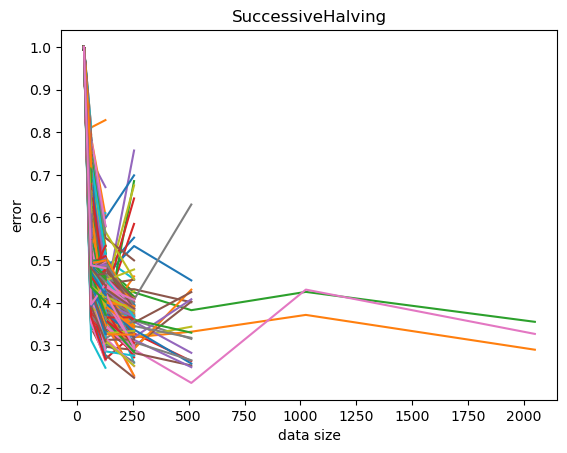

In [77]:
for i,curve in halving.curves.items():
    plt.plot(halving.anchors[:len(curve)],curve)
plt.title('SuccessiveHalving')
plt.xlabel('data size')
plt.ylabel('error')
plt.show()